# Alphavec example

In this notebook we'll walkthrough backtesting a simple cost-aware crypto trend strategy with Alphavec.

## Imports

In [1]:
import os
import sys
import logging
from pathlib import PurePath
from functools import partial
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import alphavec.backtest as av

%matplotlib inline
%reload_ext autoreload
%autoreload 3

workspace_root = str(PurePath(os.getcwd()))
sys.path.append(workspace_root)

logging.basicConfig(
    format="%(asctime)s :: %(name)s :: %(levelname)s :: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S %z",
    level=os.environ.get("LOG_LEVEL", "INFO"),
    force=True,
    handlers=[logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger()

plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Load data

Let's begin by loading our data.

We transform a flat file of daily candlestick (kline) data for a variety of crypto assets into the required format for backtesting: a single level DatetimeIndex with a column for each asset.

Close prices are used to generate our strategy weights.

Open prices are used to calculate the returns.
To prevent look-ahead bias we shift the open prices 2 periods during the backtest. This approach implies we can execute our trades at the open price of the next bar after the strategy weights are generated - a reasonable assumption in a 24 hour market like crypto.

Note the dataframe format Alphavec expects for prices: a DateTimeIndex index with prices for each asset in the columns.

In [2]:
def ohlcv_from_csv(filename):
    return pd.read_csv(
        filename,
        index_col=["symbol", "dt"],
        parse_dates=["dt"],
        dtype={
            "o": np.float64,
            "h": np.float64,
            "l": np.float64,
            "c": np.float64,
            "v": np.float64,
        },
        dayfirst=True,
    )


prices_filename = f"{workspace_root}/tests/testdata/binance-margin-1d.csv"
market = ohlcv_from_csv(prices_filename)
market = market[~market.index.duplicated()]
market = market.unstack(level=0).sort_index(axis=1).stack()

strategy_prices = pd.DataFrame(
    market.loc[:, ["c"]].unstack(level=1).droplevel(level=0, axis=1)
)

trade_prices = pd.DataFrame(
    market.loc[:, ["o"]].unstack(level=1).droplevel(level=0, axis=1)
)

display(trade_prices.tail())

symbol,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT,SOLUSDT,XRPUSDT
dt,,,,,,
2023-11-11,37301.63,0.07539,2077.72,0.8426,56.67,0.6594
2023-11-12,37129.99,0.07850,2053.16,0.8033,56.36,0.6626
2023-11-13,37064.13,0.07795,2044.69,0.8971,56.27,0.6612
2023-11-14,36462.93,0.07456,2053.65,0.8821,51.60,0.6701
2023-11-15,35551.20,0.07244,1979.40,0.9175,56.81,0.6296


## Generate Forecast

Using the prices we create a simple risk-adjusted moving average cross forecast.

Handily, all the forecasts share a common scale because we've risk adjusted using the difference in price points, rather than the more typical returns.

<Axes: xlabel='dt'>

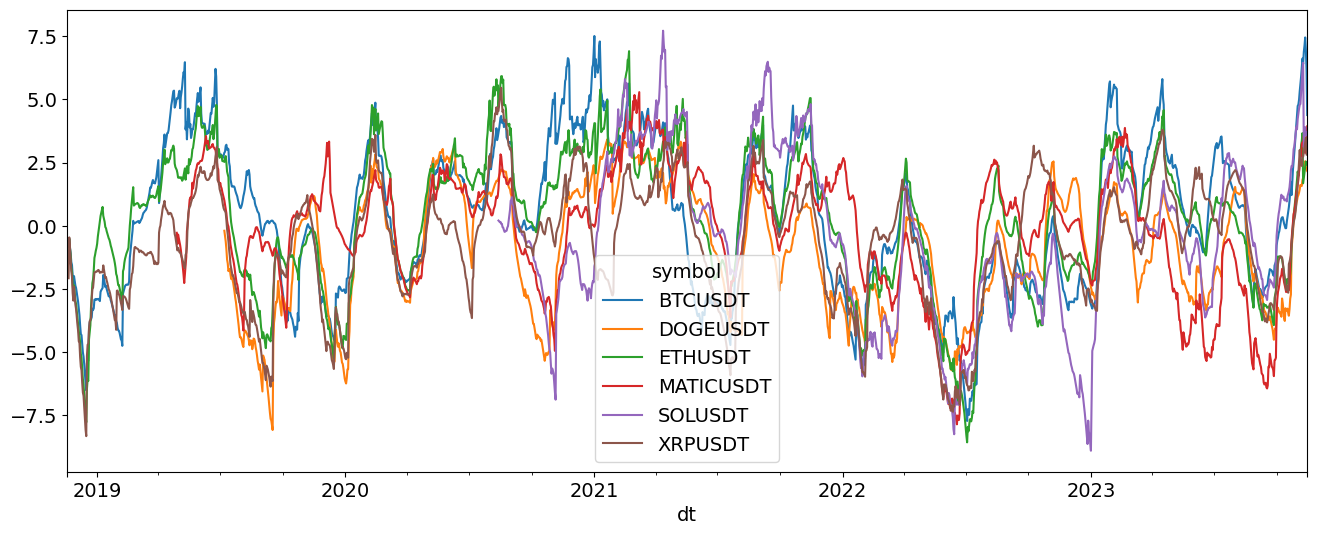

In [3]:
lookback = 16
forecast = (
    strategy_prices.ewm(span=lookback, adjust=False).mean()
    - strategy_prices.ewm(span=lookback * 4, adjust=False).mean()
).div(strategy_prices.diff().ewm(span=20).std())

forecast.plot()

## Distribute Weights

The final strategy weights are formed by normalizing the portfolio allocations so they sum to 1 at each interval.

For spice we simulate 2x leverage.

> ‼️ We do not perform any risk management in this simple example, a real-world strategy should consider how to adjust leverage for realised volatility or similar.

symbol,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT,SOLUSDT,XRPUSDT
dt,,,,,,
2023-11-11,0.665475,0.215337,0.196780,0.305156,0.328159,0.289092
2023-11-12,0.665875,0.228178,0.206964,0.257937,0.348666,0.292379
2023-11-13,0.632906,0.209982,0.230471,0.285910,0.324880,0.315852
2023-11-14,0.588359,0.214864,0.232704,0.340201,0.354222,0.269651
2023-11-15,0.452424,0.224095,0.257359,0.405969,0.369556,0.290596


<Axes: xlabel='dt'>

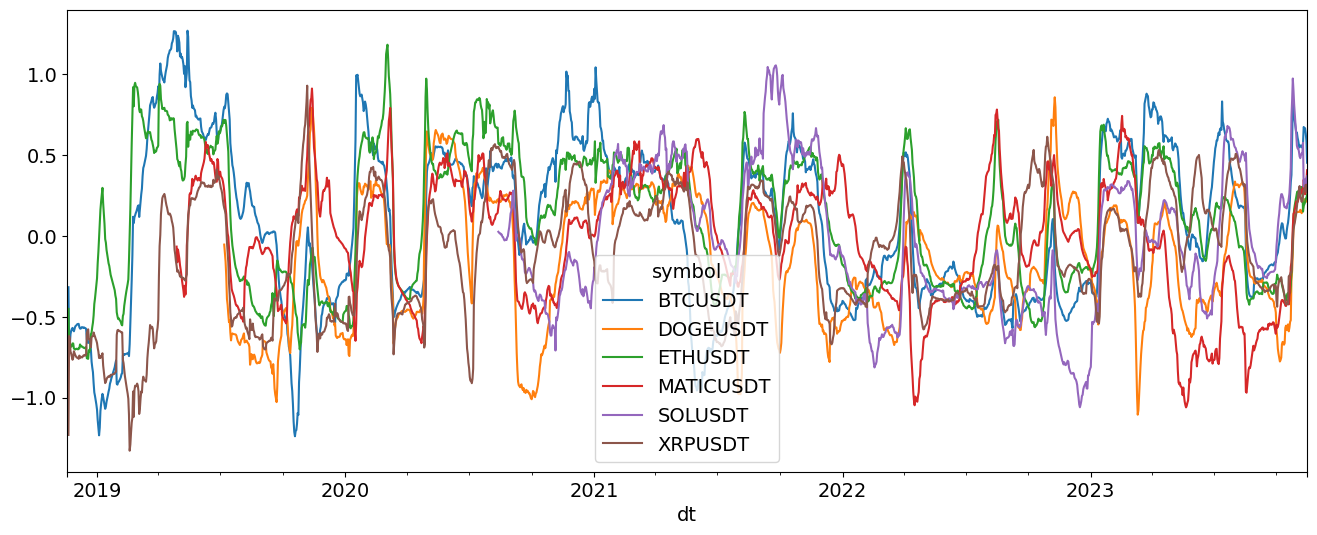

In [4]:
weights = forecast.div(forecast.abs().sum(axis=1), axis=0)
weights *= 2

display(weights.tail())
weights.plot()

## Execute Backtest

Finally we are ready to backtest.

However, we must take care to align the prices and weights.

During the backtest the returns calculated from the prices will be _shifted_ to prevent look-ahead bias.

This is a cost-aware backtest with fixed leverage. We've chosen cost parameters that mimic a typical crypto exchange.

Note how fast the backtest is even with 1000 bootstrap iterations to estimate portfolio metrics!

In [5]:
weights = weights["2019-01-01":]
trade_prices = trade_prices.mask(weights.isna())
trade_prices, weights = trade_prices.align(weights, join="inner")

perf, perf_curve, perf_sr, port_perf, port_rets = av.backtest(
    weights,
    trade_prices,
    freq_day=1,  # daily periods
    trading_days_year=365,  # crypto is a 365 market
    shift_periods=2,  # trade prices = open prices so we shift 2 periods
    commission_func=partial(
        av.pct_commission, fee=0.001
    ),  # 0.1% fee charged on each trade
    spread_pct=0.0005,  # 0.05% spread on each spread
    ann_borrow_rate=0.05,  # 5% annual borrowing rate for leveraged positions
    ann_risk_free_rate=0,  # 0% risk free rate used to calculate Sharpe ratio
    bootstrap_n=1000,  # number of bootstrap iterations to calculate confidence intervals
)

2024-06-28 09:58:40 +0100 :: root :: INFO :: Executing backtest for 6 assets over 1780 periods with 1000 bootstrap iterations...
2024-06-28 09:58:41 +0100 :: root :: INFO :: Backtest complete in 0.55 seconds.


## Analyse Results

Let's look at the performance of the strategy, starting with the asset-wise view, then the portfolio view.

Asset performance is the baseline buy-and-hold over the period.

Strategy performance is the performance of our generated weights.

We note that the BTC component of our strategy had better risk adjusted returns (Sharpe) than the baseline buy-and-hold, likewise so did SOL. However the other components underformed.

In [6]:
display(perf)

asset                                           \
          annual_sharpe annual_volatility      cagr max_drawdown   
symbol                                                             
BTCUSDT        0.680140          0.695804  0.605193    -0.766293   
DOGEUSDT       0.490918          1.450612  1.038332    -0.923328   
ETHUSDT        0.629351          0.895686  0.757164    -0.793027   
MATICUSDT      0.758151          1.493198  2.102068    -0.879694   
SOLUSDT        0.613386          1.357757  1.299816    -0.962695   
XRPUSDT        0.123421          1.065146  0.140493    -0.832385   

               strategy                                           \
          annual_sharpe annual_volatility      cagr max_drawdown   
symbol                                                             
BTCUSDT        0.929943          0.359609  0.397124    -0.225743   
DOGEUSDT       0.066670          0.473707  0.032086    -0.669582   
ETHUSDT        0.261249          0.383571  0.105400    -0.472005   
MATICUSDT      0.164729          0.512178  0.088032    -0.735848   
SOLUSDT        0.926760          0.550578  0.665714    -0.601792   
XRPUSDT       -0.452668          0.359050 -0.150010    -0.647068   

                                             
          annual_turnover annual_cost_ratio  
symbol                                       
BTCUSDT          1.308955          0.028543  
DOGEUSDT         2.986322          0.009327  
ETHUSDT          3.056987          0.012141  
MATICUSDT        5.398527          0.018493  
SOLUSDT          1.316086          0.005494  
XRPUSDT          5.695483          0.038663

Next lets review the compounded equity curves (excl. portfoilo) to see account value progression over time.

As we can observe clearly in the equity curve the buy-and-hold on MATIC performed the best in terms of absolute returns.

<Axes: xlabel='dt'>

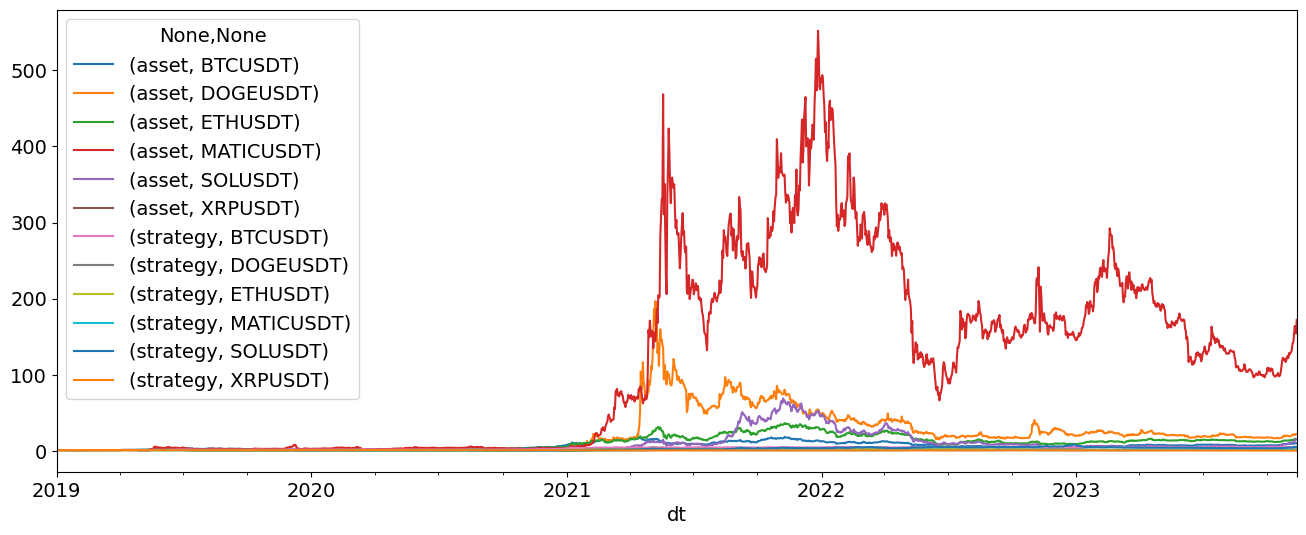

In [7]:
perf_curve.drop(("portfolio", "equity_curve"), axis=1).plot()

Similarly, lets see how risk-adjusted returns (annualized Sharpe) progress over time.

Here we can see there is no clear winner.

<Axes: xlabel='dt'>

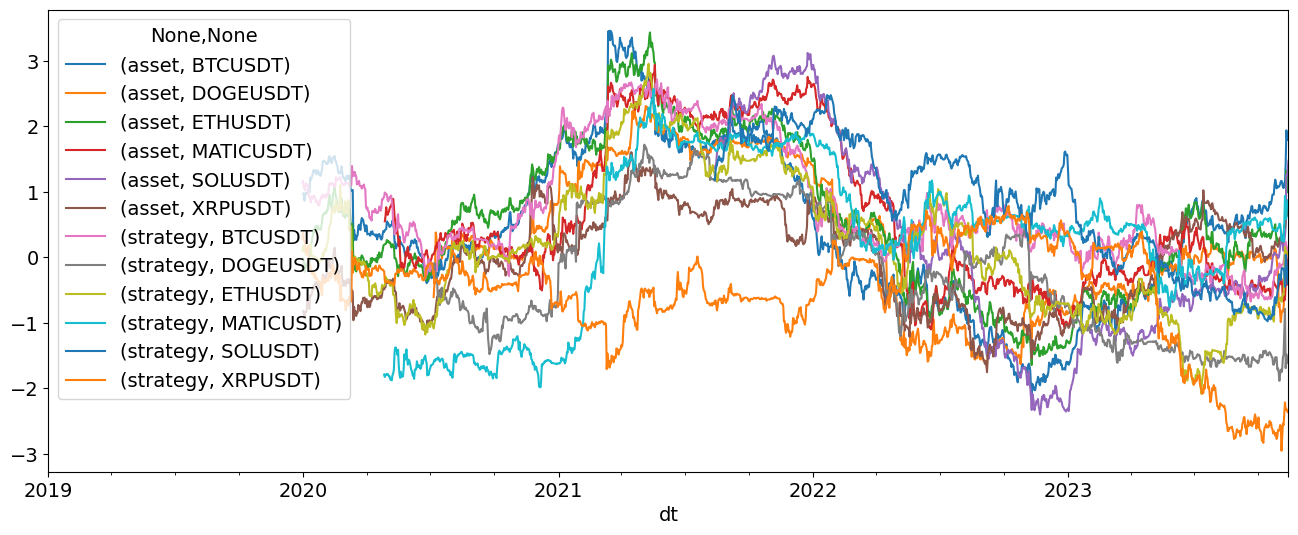

In [8]:
perf_sr.drop(("portfolio", "sharpe"), axis=1).plot()

Now we'll turn to our aggregate portfolio performance.

**Observed** is the actual backtested performance of our strategy.

But as we know backtests are fallible and are no guarantee of future performance. 

Validating the robustness of a trading strategy can take many forms. Alphavec offers a simple way to understand the potential variance of your strategy by providing estimates of the confidence interval for each metric. These estimates are generated using a bootstrap sampling method on the observed porfolio returns.

Here we observe a rather modest 0.5 Sharpe for our strategy in aggregate, with volatility at a stomach churning 140%... an expected consequence of applying fixed leverage to an already highly volatile asset class.

The lower confidence limit (p = 0.5) tells us that out-of-sample in the real world we could actually expect a negative Sharpe of -0.3 and overall a loss. Clearly we would be fool hardy to consider trading this strategy in live.

In [9]:
display(port_perf)

,annual_sharpe,annual_volatility,cagr,max_drawdown,annual_turnover,annual_cost_ratio
observed,0.5057,1.4239,1.0547,-0.9287,1.6956,0.0066
mean,0.5424,1.4210,1.6562,-0.8955,1.6956,0.0769
std,0.4546,0.0581,1.9261,0.0768,0.0000,0.2097
median,0.5337,1.4189,1.1665,-0.9097,1.6956,0.0120
ucl.95,1.4108,1.5405,6.4593,-0.7165,1.6956,0.5476
lcl.95,-0.3500,1.3129,-0.3875,-0.9958,1.6956,0.0001


Plot the compounded equity curve of the portfolio, followed by the simple cumulated returns.

The latter plot is helpful in enabling us to better see the underlying trend.

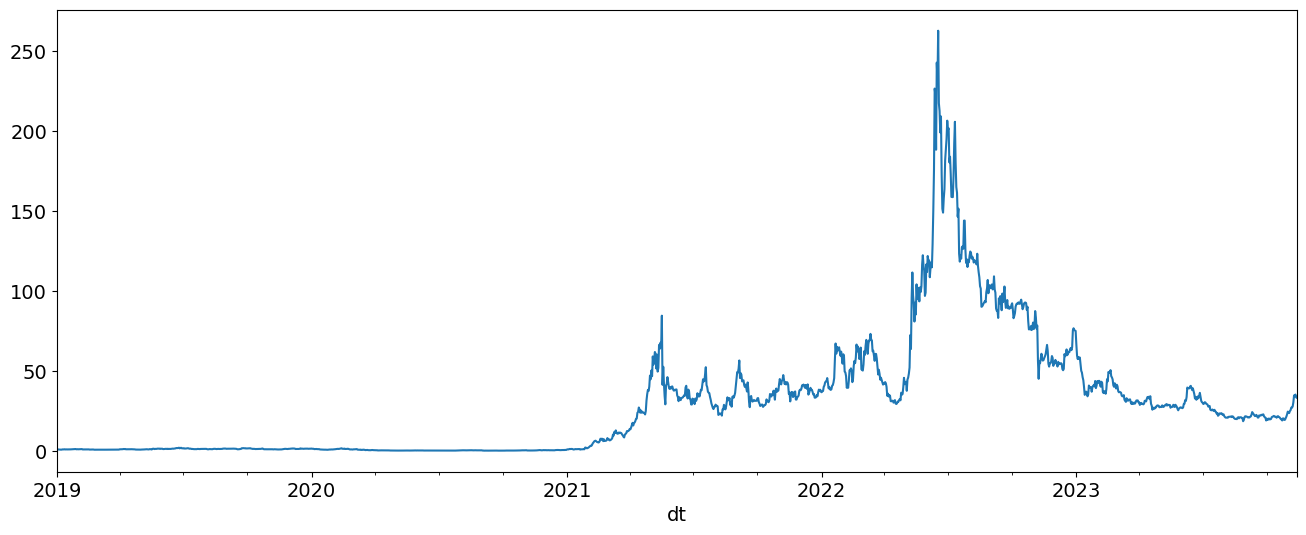

<Axes: xlabel='dt'>

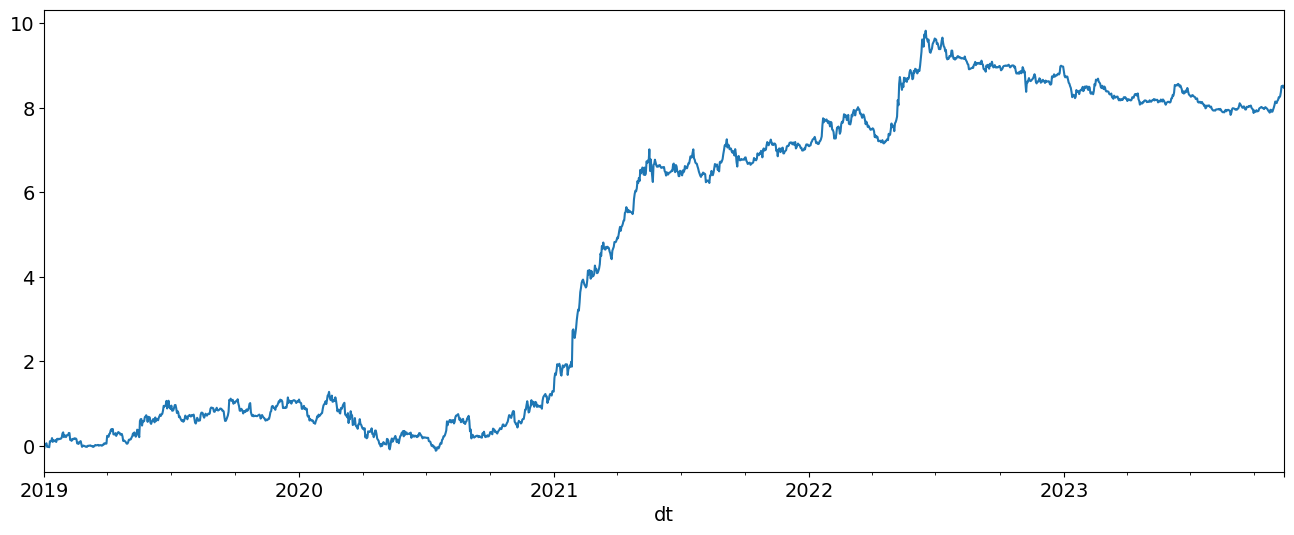

In [10]:
port_curve = perf_curve.loc[:, ("portfolio", "equity_curve")]
port_curve.plot()
plt.show()

(np.exp(port_rets) - 1).cumsum().plot()

Using the rolling Sharpe series we can get a sense of the year by year risk adjusted returns.

<Axes: xlabel='dt'>

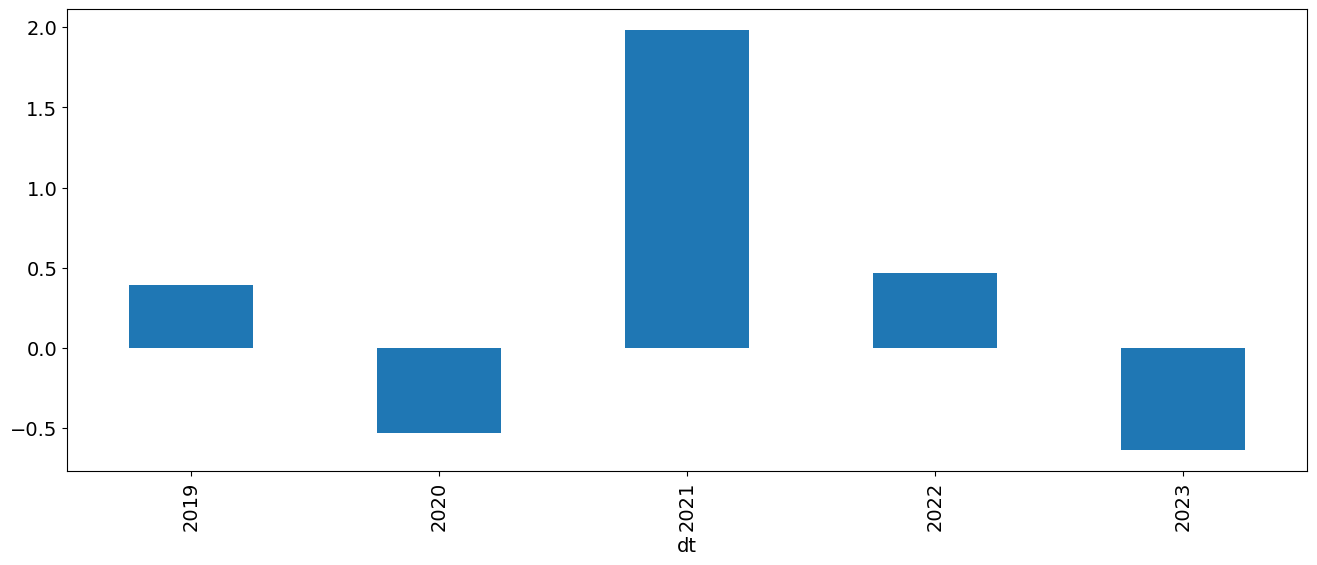

In [11]:
perf_sr.loc[:, ("portfolio", "sharpe")].resample("Y").last().rename(
    lambda x: x.strftime("%Y")
).plot(kind="bar")

The information ratio (IR) helps us understand the performance of our strategy versus a benchmark.

We use an equal weighted portfolio of BTC and ETH as our benchmark.

An IR of 0.2 is poor.

In [12]:
port_cagr = port_perf.loc["observed", "cagr"]
bench_cagr = (
    perf.loc["BTCUSDT", ("asset", "cagr")] * 0.5
    + perf.loc["ETHUSDT", ("asset", "cagr")] * 0.5
)

info_ratio = (port_cagr - bench_cagr) / port_perf.loc["observed", "annual_volatility"]

info_ratio

0.2623229593205793

Finally we look at the distribution of returns and evaluate the skew and kurtosis (fat tailedness).

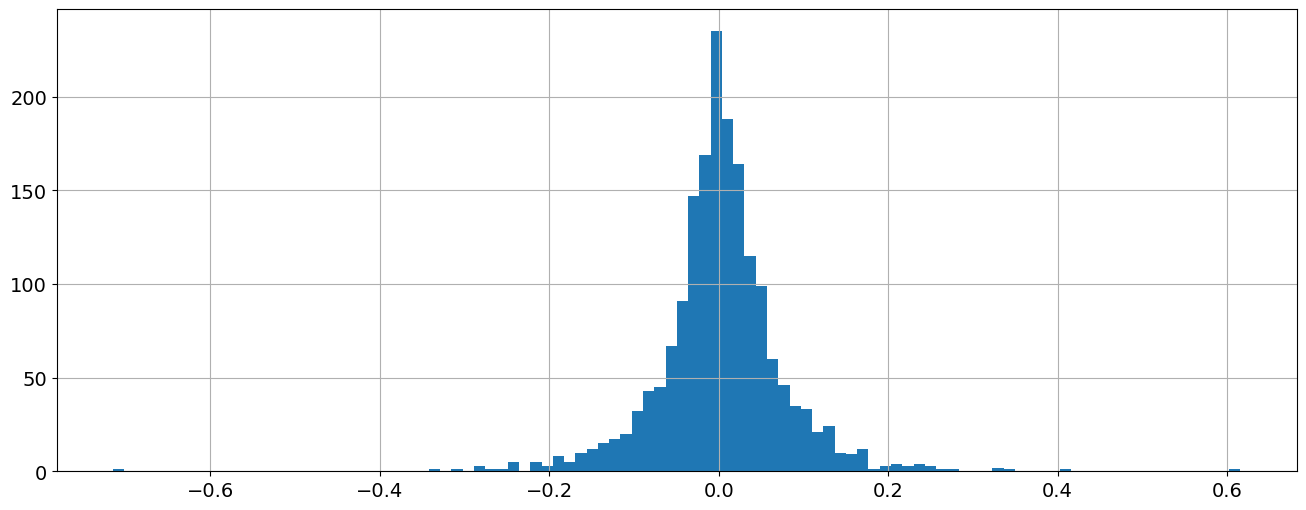

Skew -0.1450086049183156
Kurt 9.70436381372713


In [13]:
port_rets.hist(bins=100)
plt.show()
print(f"Skew {port_rets.skew()}")
print(f"Kurt {port_rets.kurtosis()}")

In conclusion, the performance of our toy strategy leaves a lot to be desired!

To understand a more sophistcated real-world variant of this strategy I validated with Alphavec read on...

## 🚀 Zero 2 Algo 🚀

As a kwant-curious retail trader are you interested in learning how to design, build and deploy a complete automated real-world strategy validated with Alphavec?

Check out my forthcoming project **Zero 2 Algo** 